In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import scipy.stats as stats
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units


import warnings
warnings.filterwarnings('ignore')

In [2]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



## Adam's trick to output the budget terms direclty 

In [3]:
## Read in CLM files 

# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/Test_MoreOutputs/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'



# yearStrings  = np.asarray(['2015','2016','2017','2018'])
yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
#                             '-07-05-60585.nc',
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])
                            ])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.003.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.003.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex() 
            
        
        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
    
        if fileCount==0:
            HTGcamDS_all = HTG_camDS
            HMGcamDS_all = HMG_camDS
             
        else: 
            HTGcamDS_all = xr.concat([HTGcamDS_all,HTG_camDS], dim='time')
            HMGcamDS_all = xr.concat([HMGcamDS_all,HMG_camDS], dim='time')
            
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))




Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [4]:
## Convert to local times...
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})



In [7]:
meanAdvHMG        = HMGcamDS_local['wprtp_ma'].values[:,:,0,0]
turbTranspHMG     = HMGcamDS_local['wprtp_ta'].values[:,:,0,0]
turbProdHMG       = HMGcamDS_local['wprtp_tp'].values[:,:,0,0]
accumHMG          = HMGcamDS_local['wprtp_ac'].values[:,:,0,0]
buoyProdHMG       = HMGcamDS_local['wprtp_bp'].values[:,:,0,0]
press1HMG         = HMGcamDS_local['wprtp_pr1'].values[:,:,0,0]
press2HMG         = HMGcamDS_local['wprtp_pr2'].values[:,:,0,0]
press3HMG         = HMGcamDS_local['wprtp_pr3'].values[:,:,0,0]
pressureApproxHMG = press1HMG+press2HMG+press3HMG
dissipationHMG    = HMGcamDS_local['wprtp_dp1'].values[:,:,0,0]

dwprtpdtHMG = HMGcamDS_local['wprtp_bt'].values[:,:,0,0]
sumTermsHMG = meanAdvHMG + turbTranspHMG + turbProdHMG + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG

residualHMG = dwprtpdtHMG - sumTermsHMG

## Other terms included in CLUBB but not necessarily in the equation: 
fluxLimitHMG     = HMGcamDS_local['wprtp_mfl'].values[:,:,0,0]
clipHMG          = HMGcamDS_local['wprtp_cl'].values[:,:,0,0]
semiImplClipHMG  = HMGcamDS_local['wprtp_sicl'].values[:,:,0,0]
flxCorrTranspHMG = HMGcamDS_local['wprtp_pd'].values[:,:,0,0]
forcHMG          = HMGcamDS_local['wprtp_forcing'].values[:,:,0,0]



In [11]:
meanAdvHTG        = HTGcamDS_local['wprtp_ma'].values[:,:,0,0]
turbTranspHTG     = HTGcamDS_local['wprtp_ta'].values[:,:,0,0]
turbProdHTG       = HTGcamDS_local['wprtp_tp'].values[:,:,0,0]
accumHTG          = HTGcamDS_local['wprtp_ac'].values[:,:,0,0]
buoyProdHTG       = HTGcamDS_local['wprtp_bp'].values[:,:,0,0]
press1HTG         = HTGcamDS_local['wprtp_pr1'].values[:,:,0,0]
press2HTG         = HTGcamDS_local['wprtp_pr2'].values[:,:,0,0]
press3HTG         = HTGcamDS_local['wprtp_pr3'].values[:,:,0,0]
pressureApproxHTG = press1HTG+press2HTG+press3HTG
dissipationHTG    = HTGcamDS_local['wprtp_dp1'].values[:,:,0,0]

dwprtpdtHTG = HTGcamDS_local['wprtp_bt'].values[:,:,0,0]
sumTermsHTG = meanAdvHTG + turbTranspHTG + turbProdHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG

residualHTG = dwprtpdtHTG - sumTermsHTG

## Other terms included in CLUBB but not necessarily in the equation: 
fluxLimitHTG     = HTGcamDS_local['wprtp_mfl'].values[:,:,0,0]
clipHTG          = HTGcamDS_local['wprtp_cl'].values[:,:,0,0]
semiImplClipHTG  = HTGcamDS_local['wprtp_sicl'].values[:,:,0,0]
flxCorrTranspHTG = HTGcamDS_local['wprtp_pd'].values[:,:,0,0]
forcHTG          = HTGcamDS_local['wprtp_forcing'].values[:,:,0,0]



[ 0.0000000e+00 -1.1994018e-23  1.8914890e-23 -3.5893297e-23
  2.2032570e-25  1.3022188e-23  3.2532018e-23  5.0087594e-23
 -1.5595439e-23 -4.2484035e-23  4.7109107e-23 -3.6286920e-23
 -2.0750235e-23 -2.1483522e-25 -2.5563789e-23  6.1438128e-24
 -2.3928448e-23  4.0721618e-23  2.1175551e-25  2.2295102e-24
 -4.1949948e-21  3.6263598e-20 -1.3486353e-20 -3.1896084e-21
 -1.2230362e-19  2.0916420e-19  1.8591711e-19  3.2483714e-19
  5.8436009e-19  5.4067172e-19  9.6561756e-20 -4.4723340e-19
  4.2351647e-18  2.0667604e-19 -3.4833171e-18 -1.0186418e-17
 -1.0249099e-18  3.2602298e-18  3.0747296e-18  2.8104553e-18
 -1.5927608e-17  9.2130080e-17 -3.5693968e-17 -1.4985707e-17
  3.1861991e-17 -1.2086144e-16  4.4669130e-17 -1.9081958e-16
 -1.6653345e-16  1.5543122e-14  7.8159701e-14 -6.2172489e-14
 -8.8817842e-15  1.5987212e-14 -9.4146912e-14 -3.5527137e-15
  4.8849813e-14 -3.1974423e-14  4.4408921e-14  1.7763568e-14
  1.6875390e-14  4.6629367e-14  4.2410520e-14 -9.9920072e-14
  1.9932254e-10]


Text(0.5, 1.0, 'HMG wprtp terms @ time 2015-06-03T14:32:15.000000000')

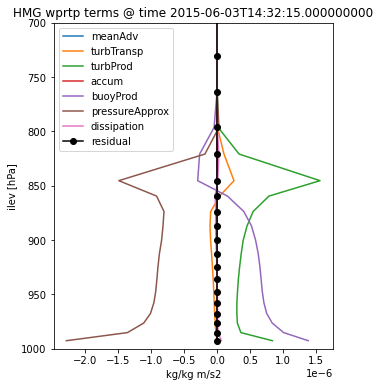

In [14]:
timeSel = 240

print(residualHMG[timeSel,:])

fig,axs = plt.subplots(1,1, figsize=(5,6))

axs.plot(meanAdvHMG[timeSel,0:-1],        HMGcamDS_local.ilev.values[0:-1], label='meanAdv')
axs.plot(turbTranspHMG[timeSel,0:-1],     HMGcamDS_local.ilev.values[0:-1], label='turbTransp')
axs.plot(turbProdHMG[timeSel,0:-1],       HMGcamDS_local.ilev.values[0:-1], label='turbProd')
axs.plot(accumHMG[timeSel,0:-1],          HMGcamDS_local.ilev.values[0:-1], label='accum')
axs.plot(buoyProdHMG[timeSel,0:-1],       HMGcamDS_local.ilev.values[0:-1], label='buoyProd')
axs.plot(pressureApproxHMG[timeSel,0:-1], HMGcamDS_local.ilev.values[0:-1], label='pressureApprox')
axs.plot(dissipationHMG[timeSel,0:-1],    HMGcamDS_local.ilev.values[0:-1], label='dissipation')
axs.plot(residualHMG[timeSel,0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


axs.legend()
axs.set_ylim([700,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HMG wprtp terms @ time '+str(HMGcamDS_local.time.values[timeSel]))




[ 0.0000000e+00 -1.1994018e-23  1.8914890e-23 -3.5893297e-23
  2.2032570e-25  1.3022188e-23  3.2532018e-23  5.0087594e-23
 -1.5595439e-23 -4.2484035e-23  4.7109107e-23 -3.6286920e-23
 -2.0750235e-23 -2.1483522e-25 -2.5563789e-23  6.1438128e-24
 -2.3928448e-23  4.0721618e-23  2.1175551e-25  2.2295102e-24
 -4.1949948e-21  3.6263598e-20 -1.3486353e-20 -3.1896084e-21
 -1.2230362e-19  2.0916420e-19  1.8591711e-19  3.2483714e-19
  5.8436009e-19  5.4067172e-19  9.6561756e-20 -4.4723340e-19
  4.2351647e-18  2.0667604e-19 -3.4833171e-18 -1.0186418e-17
 -1.0249099e-18  3.2602298e-18  3.0747296e-18  2.8104553e-18
 -1.5927608e-17  9.2130080e-17 -3.5693968e-17 -1.4985707e-17
  3.1861991e-17 -1.2086144e-16  4.4669130e-17 -1.9081958e-16
 -1.6653345e-16  1.5543122e-14  7.8159701e-14 -6.2172489e-14
 -8.8817842e-15  1.5987212e-14 -9.4146912e-14 -3.5527137e-15
  4.8849813e-14 -3.1974423e-14  4.4408921e-14  1.7763568e-14
  1.6875390e-14  4.6629367e-14  4.2410520e-14 -9.9920072e-14
  1.9932254e-10]


Text(0.5, 1.0, 'HTG wprtp terms @ time 2015-06-03T14:32:15.000000000')

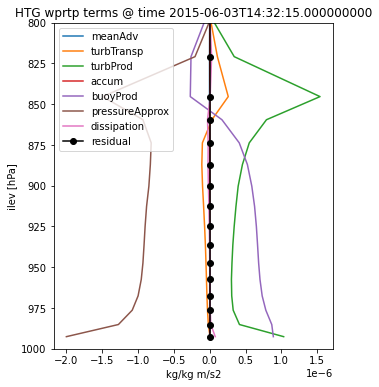

In [13]:
timeSel = 240

print(residualHMG[timeSel,:])

fig,axs = plt.subplots(1,1, figsize=(5,6))

axs.plot(meanAdvHTG[timeSel,0:-1],        HTGcamDS_local.ilev.values[0:-1], label='meanAdv')
axs.plot(turbTranspHTG[timeSel,0:-1],     HTGcamDS_local.ilev.values[0:-1], label='turbTransp')
axs.plot(turbProdHTG[timeSel,0:-1],       HTGcamDS_local.ilev.values[0:-1], label='turbProd')
axs.plot(accumHTG[timeSel,0:-1],          HTGcamDS_local.ilev.values[0:-1], label='accum')
axs.plot(buoyProdHTG[timeSel,0:-1],       HTGcamDS_local.ilev.values[0:-1], label='buoyProd')
axs.plot(pressureApproxHTG[timeSel,0:-1], HTGcamDS_local.ilev.values[0:-1], label='pressureApprox')
axs.plot(dissipationHTG[timeSel,0:-1],    HTGcamDS_local.ilev.values[0:-1], label='dissipation')
axs.plot(residualHTG[timeSel,0:-1],       HTGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


axs.legend()
axs.set_ylim([800,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HTG wprtp terms @ time '+str(HMGcamDS_local.time.values[timeSel]))





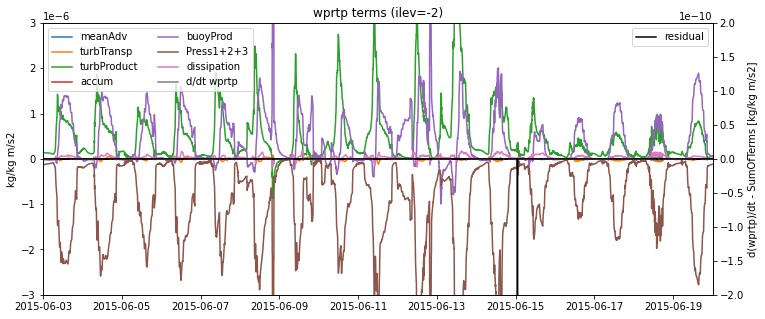

In [88]:
fig,axs = plt.subplots(1,1, figsize=(12,5))
levSel  = -2 


axs.plot(HMGcamDS_local.time.values, meanAdvHMG[:,levSel],    label='meanAdv')
axs.plot(HMGcamDS_local.time.values, turbTranspHMG[:,levSel], label='turbTransp')
axs.plot(HMGcamDS_local.time.values, turbProdHMG[:,levSel],   label='turbProduct')
axs.plot(HMGcamDS_local.time.values, accumHMG[:,levSel],      label='accum')
axs.plot(HMGcamDS_local.time.values, buoyProdHMG[:,levSel],   label='buoyProd')
axs.plot(HMGcamDS_local.time.values, pressureApproxHMG[:,levSel], label='Press1+2+3')
axs.plot(HMGcamDS_local.time.values, dissipationHMG[:,levSel],    label='dissipation')
axs.plot(HMGcamDS_local.time.values, dwprtpdtHMG[:,levSel],       label='d/dt wprtp')
# axs.plot(HMGcamDS_local.time.values, residual[:,levSel],'k',      label='residual')


# axs.plot(HMGcamDS_local.time.values, sum_terms_hmg,'r',label='SumOfTerms')
# axs.plot(dDryDays_HTG.time.values, (dDryDays_HTG.WPRTP_CLUBB_rate.values[:,-2,0,0]),'k',
#          linewidth=3,alpha=0.7,label='WPRTP_CLUBB')
axs.legend(ncol=2,loc='upper left')
axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,20)])

axs.set_ylabel('kg/kg m/s2')
axs.set_ylim([-3e-6,3e-6])
axs.set_title('wprtp terms (ilev=-2)')

ax2 = axs.twinx()
# ax2.plot(HTGcamDS_local.time.values, HTGcamDS_local.WPRTP_CLUBB.values[:,-2,0,0],'k', alpha = 0.5, label ='WPRTP_CLUBB')
# ax2.set_ylabel('wprtp [W/m2]')
# ax2.set_ylim([-200,200])

ax2.plot(HMGcamDS_local.time.values, residual[:,levSel],'k', label='residual')
ax2.set_ylabel('d(wprtp)/dt - SumOfTerms [kg/kg m/s2]')
ax2.set_ylim([-2e-10,2e-10])
ax2.legend(loc='upper right')


In [84]:
residual[:,levSel]

array([-1.4988011e-15,  3.4764998e-08,  3.5161371e-08, ...,
        1.2934098e-14,  2.7727820e-14, -2.7922109e-14], dtype=float32)

## Manual attempt

### Read data

In [3]:
## Read in CLM files 

# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/Test_MoreOutputs/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'



# yearStrings  = np.asarray(['2015','2016','2017','2018'])
yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
#                             '-07-05-60585.nc',
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])
                            ])

fileCount=0
for iYr in range(len(yearStrings)): 
#     fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.003.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.004.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
#         fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        
#         with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
#             HTG_camDS = cesm_correct_time(HTG_camDS)
#             HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex() 
            
        
        # Discard the first two days if iFile == 0  
#         if iFile==0:
#             iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
#             timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

# #             HTG_camDS      = HTG_camDS.isel(time=timeArr)
#             HMG_camDS      = HMG_camDS.isel(time=timeArr)
    
        if fileCount==0:
#             HTGcamDS_all = HTG_camDS
            HMGcamDS_all = HMG_camDS
             
        else: 
#             HTGcamDS_all = xr.concat([HTGcamDS_all,HTG_camDS], dim='time')
            HMGcamDS_all = xr.concat([HMGcamDS_all,HMG_camDS], dim='time')
            
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


Text(0.5, 1.0, 'Tau at second to bottom level in .004 run')

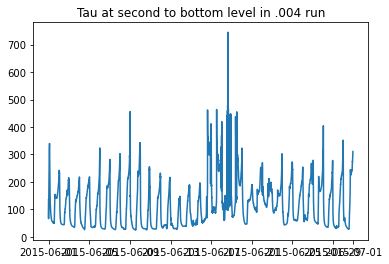

In [4]:
plt.plot(HMGcamDS_all.time.values,HMGcamDS_all.TAU_ZM_CLUBB.values[:,-2,0,0])
plt.title('Tau at second to bottom level in .004 run')

Text(0.5, 1.0, 'Tau at second to bottom level in .003 run')

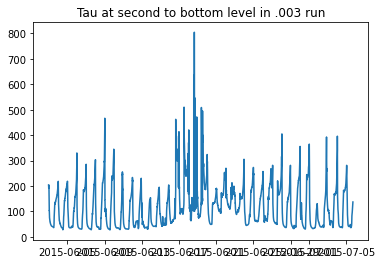

In [128]:
plt.plot(HMGcamDS_all.time.values,HMGcamDS_all.TAU_ZM_CLUBB.values[:,-2,0,0])
plt.title('Tau at second to bottom level in .003 run')

In [5]:
## Convert to local times...
# HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})


In [6]:
## Convert the turbulent moisture flux (W/m2) to a rate (m/s)
# water_density = 1000.0 # kg/m3   Density of water 

latHeat_vap   = 2.501e6  # J/kg    Latent heat of vaporization
# m2mm          = 1000.0 #         convert from m/s to mm/s

# HTGcamDS_local['WPRTP_CLUBB_rate'] = (('time','ilev','lat','lon'), 
#                                     ((HTGcamDS_local.WPRTP_CLUBB.values)/(latHeat_vap*HTGcamDS_local.RHO_CLUBB.values)))

HMGcamDS_local['WPRTP_CLUBB_rate'] = (('time','ilev','lat','lon'), 
                                    ((HMGcamDS_local.WPRTP_CLUBB.values)/(latHeat_vap*HMGcamDS_local.RHO_CLUBB.values)))



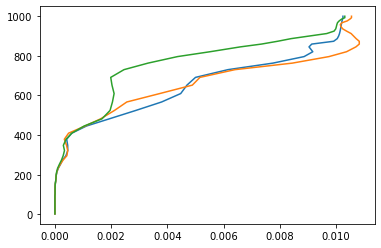

In [7]:
## Does the mixing ratio as output from CLUBB make sense, vertically?
#    Plot a few random timsteps to see - largest values at surface, etc? 
plt.plot(HMGcamDS_local['RTM_CLUBB'].values[242,:,0,0], HMGcamDS_local['ilev'].values)
plt.plot(HMGcamDS_local['RTM_CLUBB'].values[410,:,0,0], HMGcamDS_local['ilev'].values)
plt.plot(HMGcamDS_local['RTM_CLUBB'].values[83,:,0,0], HMGcamDS_local['ilev'].values)



In [8]:
## Update (10/12/2021): If we want to differentiate wrt height, but height changes with time, 
#                       need to differentiate at each time step....
#                       Ultimately it doesn't really make a noticeable difference, but seems more correct.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# ## Set up the values of heights:
# # - - - - - - - - - - - - - - - -
# p0   = HTGcamDS_local['P0'].values[0] 

# # Get pressure at each level
# plevm_HTG = HTGcamDS_local['hyam']*p0 + HTGcamDS_local['hybm']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
# plevi_HTG = HTGcamDS_local['hyai']*p0 + HTGcamDS_local['hybi']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
# plevm_HTG.attrs['units'] = "Pa"
# plevi_HTG.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm_HTG      = plevm_HTG
# zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HTG)) # Units of [m] after multiplied 
# zlevm_HTG      = plevm_HTG.copy(deep=True)
# zlevm_HTG[:,:] = zlevmHTG_vals

# #    Interfaces 
# zlevi_HTG      = plevi_HTG
# zleviHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HTG)) # Units of [m] after multiplied 
# zlevi_HTG      = plevi_HTG.copy(deep=True)
# zlevi_HTG[:,:] = zleviHTG_vals

## Do the same for HMG case
p0_HMG   = HMGcamDS_local['P0'].values[0] 


# Get pressure at each level
plevm_HMG = HMGcamDS_local['hyam']*p0_HMG + HMGcamDS_local['hybm']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
plevi_HMG = HMGcamDS_local['hyai']*p0_HMG + HMGcamDS_local['hybi']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
plevm_HMG.attrs['units'] = "Pa"
plevi_HMG.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm_HMG      = plevm_HMG
zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HMG)) # Units of [m] after multiplied 
zlevm_HMG      = plevm_HMG.copy(deep=True)
zlevm_HMG[:,:] = zlevmHMG_vals

#    Interfaces 
zlevi_HMG      = plevi_HMG
zleviHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HMG)) # Units of [m] after multiplied 
zlevi_HMG      = plevi_HMG.copy(deep=True)
zlevi_HMG[:,:] = zleviHMG_vals



## Now go ahead and get derivatives at every time step... 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
nT     = len(HMGcamDS_local.time.values)
n_ilev = len(HMGcamDS_local.ilev.values)
n_lev  = len(HMGcamDS_local.lev.values)

rhos_HMG = HMGcamDS_local['RHO_CLUBB'].values[:,-1,0,0] 

# dQTdz_HTG   = np.full([nT,n_ilev], np.nan)
dQTdz_HMG   = np.full([nT,n_ilev], np.nan)

# dWP2RTP_HTG = np.full([nT,n_ilev], np.nan)
dWP2RTP_HMG = np.full([nT,n_ilev], np.nan)

# dWPRTP_HTG  = np.full([nT,n_ilev], np.nan)
dWPRTP_HMG  = np.full([nT,n_ilev], np.nan)

# dWM_HTG  = np.full([nT,n_ilev], np.nan)
dWM_HMG  = np.full([nT,n_ilev], np.nan)

for iT in range(nT):
    # Gradient of QT wrt height 
#     QT_HTG          = HTGcamDS_local['RTM_CLUBB'].isel(time=iT,lat=0,lon=0)
#     QT_HTG['ilev']  = zlevi_HTG[iT,:].values
#     dQTdz_HTG[iT,:] = QT_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    QT_HMG          = HMGcamDS_local['RTM_CLUBB'].isel(time=iT,lat=0,lon=0)
    QT_HMG['ilev']  = zlevi_HMG[iT,:].values
    dQTdz_HMG[iT,:] = QT_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    # Gradient of WP2RTP with height
#     WP2RTP_HTG         = HTGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
#     WP2RTP_HTG['ilev'] = zlevi_HTG[iT,:].values
#     dWP2RTP_HTG[iT,:]  = WP2RTP_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WP2RTP_HMG         = HMGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
#     WP2RTP_HMG         = rhos_HMG[iT] * HMGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
    WP2RTP_HMG['ilev'] = zlevi_HMG[iT,:].values
    dWP2RTP_HMG[iT,:]  = WP2RTP_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    # Gradient of WPRTP with height
#     WPRTP_HTG         = HTGcamDS_local['WPRTP_CLUBB_rate'].isel(time=iT,lat=0,lon=0)
#     WPRTP_HTG['ilev'] = zlevi_HTG[iT,:].values
#     dWPRTP_HTG[iT,:]  = WPRTP_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WPRTP_HMG         = HMGcamDS_local['WPRTP_CLUBB_rate'].isel(time=iT,lat=0,lon=0)
    WPRTP_HMG['ilev'] = zlevi_HMG[iT,:].values
    dWPRTP_HMG[iT,:]  = WPRTP_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    # Gradient of WM_ZT_CLUBB wrt height 
#     WM_HTG          = HTGcamDS_local['WM_ZM_CLUBB'].isel(time=iT,lat=0,lon=0)
#     WM_HTG['ilev']  = zlevi_HTG[iT,:].values
#     dWM_HTG[iT,:]   = WM_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WM_HMG          = HMGcamDS_local['WM_ZM_CLUBB'].isel(time=iT,lat=0,lon=0)
    WM_HMG['ilev']  = zlevi_HMG[iT,:].values
    dWM_HMG[iT,:]   = WM_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    if (iT % 500)==0:
        print('Done with %.2f percent of timesteps' % ((iT/nT)*100))

# HTGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dQTdz_HTG)
HMGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dQTdz_HMG)

# HTGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dWP2RTP_HTG)
HMGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dWP2RTP_HMG)

# HTGcamDS_local['dWPRTP_CLUBBdz'] = (('time','ilev'), dWPRTP_HTG)
HMGcamDS_local['dWPRTP_CLUBBdz'] = (('time','ilev'), dWPRTP_HMG)

# HTGcamDS_local['dWdz'] = (('time','ilev'), dWM_HTG)
HMGcamDS_local['dWdz'] = (('time','ilev'), dWM_HMG)

# dWPRTPdt_HTG  = HTGcamDS_local['WPRTP_CLUBB_rate'].differentiate("time",datetime_unit="s")
dWPRTPdt_HMG  = HMGcamDS_local['WPRTP_CLUBB_rate'].differentiate("time",datetime_unit="s")


Done with 0.00 percent of timesteps
Done with 5.79 percent of timesteps
Done with 11.57 percent of timesteps
Done with 17.36 percent of timesteps
Done with 23.15 percent of timesteps
Done with 28.93 percent of timesteps
Done with 34.72 percent of timesteps
Done with 40.50 percent of timesteps
Done with 46.29 percent of timesteps
Done with 52.08 percent of timesteps
Done with 57.86 percent of timesteps
Done with 63.65 percent of timesteps
Done with 69.44 percent of timesteps
Done with 75.22 percent of timesteps
Done with 81.01 percent of timesteps
Done with 86.80 percent of timesteps
Done with 92.58 percent of timesteps
Done with 98.37 percent of timesteps


In [9]:
# 2nd derivative of WPRTP wrt height

# d2WPRTPdz2_HTG = np.full([nT,n_ilev], np.nan)
d2WPRTPdz2_HMG = np.full([nT,n_ilev], np.nan)

for iT in range(nT):
    # Gradient of QT wrt height 
#     dWPRTPdz_HTG         = HTGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
#     dWPRTPdz_HTG['ilev'] = zlevi_HTG[iT,:].values
#     d2WPRTPdz2_HTG[iT,:] = dWPRTPdz_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    dWPRTPdz_HMG         = HMGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
    dWPRTPdz_HMG['ilev'] = zlevi_HMG[iT,:].values
    d2WPRTPdz2_HMG[iT,:] = dWPRTPdz_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
# HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), d2WPRTPdz2_HTG)
HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), d2WPRTPdz2_HMG)


In [17]:
## Now define all of the terms that go into the wprtp budget...
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

C6   = 4.0
C7   = 0.5 
K6   = 0.375
nu6  = 5.0
grav = 9.8


# meanAdv        = -(HTGcamDS_local['WM_ZT_CLUBB'].values[:,:,0,0]*HTGcamDS_local['dWPRTP_CLUBBdz'].values[:,:])
# turbTransp     = -(HTGcamDS_local['dWP2RTP_CLUBBdz'].values[:,:])
# turbProd       = -(HTGcamDS_local['WP2_CLUBB'].values[:,:,0,0] * HTGcamDS_local['dRTM_CLUBBdz'].values[:,:])
# accum          = -(HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0] * HTGcamDS_local['dWdz'].values[:,:])
# buoyProd       = (grav/HTGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*(HTGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
# # pressureApprox = -(HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0]/HTGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0])-(0.5*(9.8/HTGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*(HTGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])) 
# press1 = -((C6/HTGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0])*HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0])
# press2 = C7*HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0]*HTGcamDS_local['dWdz'].values[:,:]
# press3 = -(C7*(grav/HTGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*HTGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
# pressureApprox = press1+press2+press3
# dissipation    = -((K6+nu6) * HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,:])

# sumTerms = meanAdv+turbTransp+turbProd+accum+buoyProd+pressureApprox+dissipation
# residual = dWPRTPdt_HTG[:,:,0,0] - sumTerms


## Do the same for the HMG case
meanAdvHMG        = -(HMGcamDS_local['WM_ZM_CLUBB'].values[:,:,0,0]*HMGcamDS_local['dWPRTP_CLUBBdz'].values[:,:])
turbTranspHMG     = -(HMGcamDS_local['dWP2RTP_CLUBBdz'].values[:,:])
turbProdHMG       = -(HMGcamDS_local['WP2_CLUBB'].values[:,:,0,0] * HMGcamDS_local['dRTM_CLUBBdz'].values[:,:])
accumHMG          = -(HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0] * HMGcamDS_local['dWdz'].values[:,:])
buoyProdHMG       = (grav/HMGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*(HMGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
# pressureApprox = -(HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0]/HTGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0])-(0.5*(9.8/HTGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*(HTGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])) 
press1HMG = -((C6/HMGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0])*HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0])
press2HMG = C7*HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0]*HMGcamDS_local['dWdz'].values[:,:]
press3HMG = -(C7*(grav/HMGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*HMGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
pressureApproxHMG = press1HMG+press2HMG+press3HMG
dissipationHMG    = ((K6+nu6) * HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,:])

sumTermsHMG = meanAdvHMG+turbTranspHMG+turbProdHMG+accumHMG+buoyProdHMG+pressureApproxHMG+dissipationHMG
residualHMG = dWPRTPdt_HMG[:,:,0,0] - sumTermsHMG



<xarray.DataArray 'WPRTP_CLUBB_rate' (ilev: 65)>
array([-1.23436414e-16, -7.16296633e-17, -8.48506282e-17, -1.56961760e-16,
       -1.73574715e-16, -1.97869933e-16, -2.08675674e-16, -2.36266194e-16,
       -2.45012823e-16, -2.55000582e-16, -2.53540774e-16, -2.53705578e-16,
       -2.52443724e-16, -2.51036871e-16, -2.49152894e-16, -2.46714568e-16,
       -2.46951400e-16, -2.52606256e-16, -2.75490823e-16, -2.82617737e-15,
       -2.12423047e-12, -9.55422661e-13, -1.29302802e-13, -5.65197707e-13,
       -9.21644317e-13, -2.49264233e-12, -6.56551385e-12, -4.73776143e-12,
       -5.28677742e-12, -1.15190126e-11, -2.04263961e-11, -3.74011441e-11,
       -5.02516098e-11, -3.89718434e-11, -3.87911311e-11,  1.76601306e-11,
        2.09914932e-11, -3.20277923e-13, -9.96811803e-11, -3.41864687e-10,
       -4.12646271e-10, -3.34173288e-10, -1.34030049e-10,  1.02912627e-10,
       -1.46697554e-10, -7.66492974e-10, -1.10027286e-09, -8.47241086e-10,
       -3.69036958e-10, -1.43179895e-10, -4.0454798

Text(0.5, 1.0, 'HMG wprtp terms @ time 2015-06-01T07:47:15.000000000')

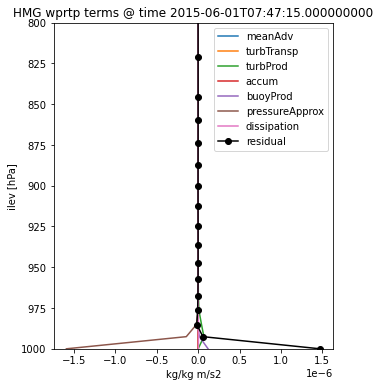

In [27]:
timeSel = 160

print(residualHMG[timeSel,:])

fig,axs = plt.subplots(1,1, figsize=(5,6))

axs.plot(meanAdvHMG[timeSel,:], HMGcamDS_local.ilev.values, label='meanAdv')
axs.plot(turbTranspHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbTransp')
axs.plot(turbProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbProd')
axs.plot(accumHMG[timeSel,:], HMGcamDS_local.ilev.values, label='accum')
axs.plot(buoyProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='buoyProd')
axs.plot(pressureApproxHMG[timeSel,:], HMGcamDS_local.ilev.values, label='pressureApprox')
axs.plot(dissipationHMG[timeSel,:], HMGcamDS_local.ilev.values, label='dissipation')
axs.plot(residualHMG[timeSel,:], HMGcamDS_local.ilev.values,'ko-', label='residual')



axs.legend()
axs.set_ylim([800,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HMG wprtp terms @ time '+str(HMGcamDS_local.time.values[timeSel]))



In [14]:
# timeSel = 240

# fig,axs = plt.subplots(1,1, figsize=(5,6))

# axs.plot(meanAdv[timeSel,:], HTGcamDS_local.ilev.values, label='meanAdv')
# axs.plot(turbTransp[timeSel,:], HTGcamDS_local.ilev.values, label='turbTransp')
# axs.plot(turbProd[timeSel,:], HTGcamDS_local.ilev.values, label='turbProd')
# axs.plot(accum[timeSel,:], HTGcamDS_local.ilev.values, label='accum')
# axs.plot(buoyProd[timeSel,:], HTGcamDS_local.ilev.values, label='buoyProd')
# axs.plot(pressureApprox[timeSel,:], HTGcamDS_local.ilev.values, label='pressureApprox')
# axs.plot(dissipation[timeSel,:], HTGcamDS_local.ilev.values, label='dissipation')
# axs.plot(residual[timeSel,:], HTGcamDS_local.ilev.values,'k', label='residual')



# axs.legend(ncol=2)
# axs.set_ylim([600,1000])
# axs.invert_yaxis()
# axs.set_xlabel('kg/kg m/s2')
# axs.set_ylabel('ilev [hPa]')
# axs.set_title('HTG wprtp terms @ time '+str(HTGcamDS_local.time.values[timeSel]))



In [15]:
# timeSel = 240

# fig,axs = plt.subplots(1,1, figsize=(5,6))

# axs.plot(meanAdvHMG[timeSel,:], HTGcamDS_local.ilev.values, label='meanAdv')
# axs.plot(turbTranspHMG[timeSel,:], HTGcamDS_local.ilev.values, label='turbTransp')
# axs.plot(turbProdHMG[timeSel,:], HTGcamDS_local.ilev.values, label='turbProd')
# axs.plot(accumHMG[timeSel,:], HTGcamDS_local.ilev.values, label='accum')
# axs.plot(buoyProdHMG[timeSel,:], HTGcamDS_local.ilev.values, label='buoyProd')
# axs.plot(pressureApproxHMG[timeSel,:], HTGcamDS_local.ilev.values, label='pressureApprox')
# axs.plot(dissipationHMG[timeSel,:], HTGcamDS_local.ilev.values, label='dissipation')
# axs.plot(residualHMG[timeSel,:], HTGcamDS_local.ilev.values,'k', label='residual')

# axs.legend(ncol=2)
# axs.set_ylim([600,1000])
# axs.invert_yaxis()
# axs.set_xlabel('kg/kg m/s2')
# axs.set_ylabel('ilev [hPa]')
# axs.set_title('HMG wprtp terms @ time '+str(HTGcamDS_local.time.values[timeSel]))


#### Check out log file for more info

In [16]:
logFile=dataDir+'atm.log.1006984.chadmin1.ib0.cheyenne.ucar.edu.211013-091314_003'

with open(logFile) as f:
    lines = f.readlines()
    
    

In [17]:
# First get where each output for a timestep ends

endTimeLines = []

for iLines in range(len(lines)):
    if lines[iLines].startswith('WSHIST: writing time sample ')==True:
        endTimeLines = np.append(endTimeLines,iLines)
        


In [21]:
endTimeLines

array([6.648000e+03, 7.711000e+03, 8.736000e+03, ..., 8.864368e+06,
       8.865393e+06, 8.866418e+06])

In [34]:
timestepSection = lines[int(endTimeLines[0]):int(endTimeLines[1])]

# Zeta stays at a constant value for timesteps, so just use the first  
lineData = [item for item in timestepSection if item.startswith(' MDF:  Value of lhs_pr1_wprtp =')]
strArr    = lineData[1].split('=')
data      = strArr[1].split('\n')


In [169]:
# counter to make sure we're using the final vlaues 

test = np.full([1,65], np.nan)

timestepSection = lines[int(endTimeLines[0]):int(endTimeLines[1])]

lastVal = 0 
for iLine in range(len(timestepSection)):
    if timestepSection[iLine].startswith(' MDF:  Value of lhs_pr1_wprtp ='):
#         print(timestepSection[iLine:iLine+22])
        allValues   = timestepSection[iLine:iLine+22]

        line1 = allValues[0].split('=')[1]
        test[0,0] = float(line1.split()[0])
        test[0,1] = float(line1.split()[1])
        
        fillCounter = 0 
        for iSelLines in range(len(allValues)-1):
            test[0,fillCounter+2] = float(allValues[iSelLines+1].split()[0])
            test[0,fillCounter+3] = float(allValues[iSelLines+1].split()[1])
            test[0,fillCounter+4] = float(allValues[iSelLines+1].split()[2])
            fillCounter=fillCounter+3
    
        
        print(test[0,:])


[0.         0.02945347 0.03924458 0.10657713 0.01211948 0.00111111
 0.00111111 0.00111111 0.00111111 0.00444444 0.00451966 0.00669883
 0.01880734 0.04342613 0.08380923 0.1570097  0.13950915 0.1278269
 0.12007952 0.10450902 0.09397578 0.09387345 0.09590643 0.09155763
 0.0843875  0.08208033 0.08079161 0.07595755 0.07038928 0.06667601
 0.06506788 0.06886173 0.07950428 0.09870842 0.13491762 0.1674449
 0.18585048 0.19478809 0.19540374 0.19126725 0.1907293  0.19113619
 0.01518414 0.00111111 0.00444444 0.20384513 0.20289535 0.20483411
 0.20877777 0.21641042 0.22402544 0.22746396 0.23086492 0.23141635
 0.22903595 0.21938866 0.20651486 0.20387115 0.20558357 0.20881586
 0.21825756 0.22481724 0.29467835 0.70502085 0.        ]
[0.         0.05999742 0.0361366  0.08547819 0.01371039 0.0011146
 0.00111602 0.00111674 0.00111576 0.00445399 0.00458524 0.00678265
 0.01897028 0.04453533 0.08428002 0.1570079  0.13950968 0.1278266
 0.12007945 0.10450906 0.09397587 0.09387347 0.0959064  0.09155762
 0.084387

In [167]:
allValues[iSelLines+1].split()

['3.924457814345171E-002', '0.106577133818984', '1.211947618531914E-002']

In [58]:
## Find values of variables in timestepSection: 

C6rt_Skw_func     = np.full([len(endTimeLines),65], np.nan)
C7_Skw_fnc        = np.full([len(endTimeLines),65], np.nan) 
C6rt_Skw_funcDamp = np.full([len(endTimeLines),65], np.nan)
lhs_pr1_wprtp     = np.full([len(endTimeLines),65], np.nan)
Kw6               = np.full([len(endTimeLines),65], np.nan)

for iTimes in range(len(endTimeLines)):
    if iTimes==0: 
        timestepSection = lines[0:int(endTimeLines[iTimes])]
    else:
        timestepSection = lines[int(endTimeLines[iTimes-1]):int(endTimeLines[iTimes])]
            
    for iLine in range(len(timestepSection)):
        ## C6_skw_fnc before any damping applied 
        # - - - - -  - - - - - - - - - - - - - - - - - - - - - - - - -
        if timestepSection[iLine].startswith(' MDF:   Value of C6rt_Skw_fnc(1:gr%nz) ='):
            allValues   = timestepSection[iLine:iLine+23]
            
            # Now append all the values per timestep
            #     First value on line with MDF: ... =, so grab that first 
            C6rt_Skw_func[iTimes,0] = float(allValues[0].split('=')[1])
            fillCounter = 0 
            for iSelLines in range(len(allValues)-2):
                C6rt_Skw_func[iTimes,fillCounter+1] = float(allValues[iSelLines+1].split('   ')[1])
                C6rt_Skw_func[iTimes,fillCounter+2] = float(allValues[iSelLines+1].split('   ')[3])
                C6rt_Skw_func[iTimes,fillCounter+3] = float(allValues[iSelLines+1].split('   ')[5])
                fillCounter=fillCounter+3
            # Last line only has one value, so append that too 
            C6rt_Skw_func[iTimes,-1] = float(allValues[-1].split('  ')[1])
            
        ## C7_Skw_fnc 
        # - - - - -  - - - - - - - - - - - - - - - - - - - - - - - - -
        elif timestepSection[iLine].startswith(' MDF:   Value of C7_Skw_fnc(1:gr%nz) = '):
            allValues   = timestepSection[iLine:iLine+23]
            
            # Now append all the values per timestep
            #     First value on line with MDF: ... =, so grab that first 
            C7_Skw_fnc[iTimes,0] = float(allValues[0].split('=')[1])
            fillCounter = 0 
            for iSelLines in range(len(allValues)-2):
                C7_Skw_fnc[iTimes,fillCounter+1] = float(allValues[iSelLines+1].split('   ')[0])
                C7_Skw_fnc[iTimes,fillCounter+2] = float(allValues[iSelLines+1].split('   ')[2])
                C7_Skw_fnc[iTimes,fillCounter+3] = float(allValues[iSelLines+1].split('   ')[4])
                fillCounter=fillCounter+3
            # Last line only has one value, so append that too 
            C7_Skw_fnc[iTimes,-1] = float(allValues[-1].split('  ')[1])
            
        ## C6_skw_fnc AFTER any damping applied 
        # - - - - -  - - - - - - - - - - - - - - - - - - - - - - - - -
        if timestepSection[iLine].startswith(' MDF:   Value of C6rt_Skw_fnc(1:gr%nz) after any damping ='):
            allValues   = timestepSection[iLine+1:iLine+23]
            
            # Now append all the values per timestep
            #     No more values on first line, and last line has two values
            fillCounter = 0 
            for iSelLines in range(len(allValues)-1):
                C6rt_Skw_funcDamp[iTimes,fillCounter+0] = float(allValues[iSelLines].split('   ')[1])
                C6rt_Skw_funcDamp[iTimes,fillCounter+1] = float(allValues[iSelLines].split('   ')[3])
                C6rt_Skw_funcDamp[iTimes,fillCounter+2] = float(allValues[iSelLines].split('   ')[5])
                fillCounter=fillCounter+3

            C6rt_Skw_funcDamp[iTimes,-2] = float(allValues[-1].split('   ')[1])
            C6rt_Skw_funcDamp[iTimes,-1] = float(allValues[-1].split('   ')[3])
            
        ## lhs_pr1_wprtp
        # - - - - -  - - - - - - - - - - - - - - - - - - - - - - - - -
        if timestepSection[iLine].startswith(' MDF:  Value of lhs_pr1_wprtp ='):
            allValues   = timestepSection[iLine:iLine+22]
            
            # Now append all the values per timestep
            #     First line now has two values
            line1 = allValues[0].split('=')[1]
            lhs_pr1_wprtp[iTimes,0] = float(line1.split()[0])
            lhs_pr1_wprtp[iTimes,1] = float(line1.split()[1])

            fillCounter = 0 
            for iSelLines in range(len(allValues)-1):
                lhs_pr1_wprtp[iTimes,fillCounter+2] = float(allValues[iSelLines+1].split()[0])
                lhs_pr1_wprtp[iTimes,fillCounter+3] = float(allValues[iSelLines+1].split()[1])
                lhs_pr1_wprtp[iTimes,fillCounter+4] = float(allValues[iSelLines+1].split()[2])
                fillCounter=fillCounter+3
                
        ## Kw6
        # - - - - -  - - - - - - - - - - - - - - - - - - - - - - - - -
        if timestepSection[iLine].startswith(' MDF:  Value of Kw6(1:gr%nz) ='):
            allValues   = timestepSection[iLine:iLine+22]
            
            # Now append all the values per timestep
            #     First line now has two values
            line1 = allValues[0].split('=')[1]
            Kw6[iTimes,0] = float(line1.split()[0])
            Kw6[iTimes,1] = float(line1.split()[1])

            fillCounter = 0 
            for iSelLines in range(len(allValues)-1):
                Kw6[iTimes,fillCounter+2] = float(allValues[iSelLines+1].split()[0])
                Kw6[iTimes,fillCounter+3] = float(allValues[iSelLines+1].split()[1])
                Kw6[iTimes,fillCounter+4] = float(allValues[iSelLines+1].split()[2])
                fillCounter=fillCounter+3


In [32]:
np.flip(lhs_pr1_wprtp[0,:])

array([0.        , 0.70502085, 0.29467835, 0.22481724, 0.21825756,
       0.20881586, 0.20558357, 0.20387115, 0.20651486, 0.21938866,
       0.22903595, 0.23141635, 0.23086492, 0.22746396, 0.22402544,
       0.21641042, 0.20877777, 0.20483411, 0.20289535, 0.20384513,
       0.00444444, 0.00111111, 0.01518414, 0.19113619, 0.1907293 ,
       0.19126725, 0.19540374, 0.19478809, 0.18585048, 0.1674449 ,
       0.13491762, 0.09870842, 0.07950428, 0.06886173, 0.06506788,
       0.06667601, 0.07038928, 0.07595755, 0.08079161, 0.08208033,
       0.0843875 , 0.09155763, 0.09590643, 0.09387345, 0.09397578,
       0.10450902, 0.12007952, 0.1278269 , 0.13950915, 0.1570097 ,
       0.08380923, 0.04342613, 0.01880734, 0.00669883, 0.00451966,
       0.00444444, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.01211948, 0.10657713, 0.03924458, 0.02945347, 0.        ])

In [31]:
testPress1 = ((C6rt_Skw_func/HMGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0]))

testPress1[0,:]

array([0.19572081, 0.19572081, 0.06772887, 0.03838565, 0.03949158,
       0.04082487, 0.04205643, 0.04409554, 0.04658517, 0.05156972,
       0.05451798, 0.05608093, 0.05612347, 0.05581614, 0.05514436,
       0.05366501, 0.05215139, 0.05119821, 0.0510975 , 0.05153767,
       0.00111111, 0.00111111, 0.00111111, 0.04884442, 0.04881952,
       0.04923173, 0.05013171, 0.05009305, 0.0481143 , 0.04334094,
       0.03535959, 0.02662046, 0.02165046, 0.01886348, 0.01788598,
       0.01817714, 0.01910885, 0.02049243, 0.02164136, 0.02208935,
       0.0226942 , 0.02442143, 0.02560464, 0.02521626, 0.02536519,
       0.02786878, 0.03171146, 0.03388973, 0.03706471, 0.04085022,
       0.013086  , 0.00482709, 0.00269741, 0.00167471, 0.00112991,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00926887, 0.03304062, 0.02811865, 0.02618198])

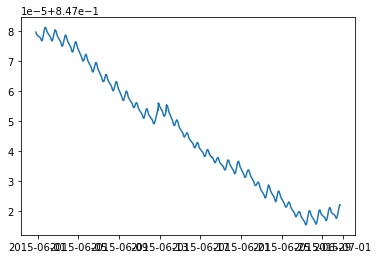

In [76]:
# plt.plot(HMGcamDS_local.time.values[10::], C6rt_Skw_func[10::,-2])
# plt.plot(HMGcamDS_local.time.values[10::], C6rt_Skw_funcDamp[10::,-2])
plt.plot(HMGcamDS_local.time.values[10::], C7_Skw_fnc[10::,-2])



In [107]:
# 2nd derivative of WPRTP wrt height

# d2WPRTPdz2_HTG = np.full([nT,n_ilev], np.nan)
d2WPRTPdz2_HMG = np.full([nT,n_ilev], np.nan)
nu6  = 5.0

for iT in range(nT):
    # Gradient of QT wrt height 
#     dWPRTPdz_HTG         = HTGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
#     dWPRTPdz_HTG['ilev'] = zlevi_HTG[iT,:].values
#     d2WPRTPdz2_HTG[iT,:] = dWPRTPdz_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    dWPRTPdz_HMG         = (np.flip(Kw6[iT,:])+nu6)*HMGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
    dWPRTPdz_HMG['ilev'] = zlevi_HMG[iT,:].values
    d2WPRTPdz2_HMG[iT,:] = dWPRTPdz_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
# HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), d2WPRTPdz2_HTG)
HMGcamDS_local['dWPRTP_CLUBB_RATEdz2_includeConst'] = (('time','ilev'), d2WPRTPdz2_HMG)



Value of press1 at ilev=-1:  -4.772085320974288e-06
Value of press2 at ilev=-1:  -3.0939740933387024e-10
Value of press3 at ilev=-1:  -1.01962021791572e-06
Value of residual at ilev=-1:  3.7151660647406915e-06


Text(0.5, 1.0, 'HMG wprtp terms @ time 2015-06-01T14:27:15.000000000')

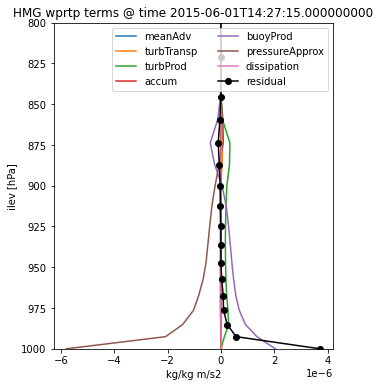

In [116]:
## Now define all of the terms that go into the wprtp budget...
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# C6   = 4.0
# C7   = 0.5 
K6   = 0.375
C6   = np.flip(C6rt_Skw_func)
C7   = np.flip(C7_Skw_fnc)
# K6   = np.flip(Kw6_2)

nu6  = 5.0
grav = 9.8



## Do the same for the HMG case
meanAdvHMG        = -(HMGcamDS_local['WM_ZM_CLUBB'].values[:,:,0,0]*HMGcamDS_local['dWPRTP_CLUBBdz'].values[:,:])
turbTranspHMG     = -(HMGcamDS_local['dWP2RTP_CLUBBdz'].values[:,:])
turbProdHMG       = -(HMGcamDS_local['WP2_CLUBB'].values[:,:,0,0] * HMGcamDS_local['dRTM_CLUBBdz'].values[:,:])
accumHMG          = -(HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0] * HMGcamDS_local['dWdz'].values[:,:])
buoyProdHMG       = (grav/HMGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*(HMGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
press1HMG = -((C6/HMGcamDS_local['TAU_ZM_CLUBB'].values[:,:,0,0])*HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0])
press2HMG = C7*HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,:,0,0]*HMGcamDS_local['dWdz'].values[:,:]
press3HMG = -(C7*(grav/HMGcamDS_local['THV_DS_ZM_CLUBB'].values[:,:,0,0])*HMGcamDS_local['RTPTHVP_CLUBB'].values[:,:,0,0])
pressureApproxHMG = press1HMG+press2HMG+press3HMG
# dissipationHMG    = ((K6+nu6) * HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,:])
dissipationHMG    = ( HMGcamDS_local['dWPRTP_CLUBB_RATEdz2_includeConst'].values[:,:])



sumTermsHMG = meanAdvHMG+turbTranspHMG+turbProdHMG+accumHMG+buoyProdHMG+pressureApproxHMG+dissipationHMG
residualHMG = dWPRTPdt_HMG.values[:,:,0,0] - sumTermsHMG


## Plot balance?
timeSel = 240
print('Value of press1 at ilev=-1: ', press1HMG[timeSel,-1])
print('Value of press2 at ilev=-1: ', press2HMG[timeSel,-1])
print('Value of press3 at ilev=-1: ', press3HMG[timeSel,-1])
print('Value of residual at ilev=-1: ', residualHMG[timeSel,-1])

fig,axs = plt.subplots(1,1, figsize=(5,6))

axs.plot(meanAdvHMG[timeSel,:], HMGcamDS_local.ilev.values, label='meanAdv')
axs.plot(turbTranspHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbTransp')
axs.plot(turbProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbProd')
axs.plot(accumHMG[timeSel,:], HMGcamDS_local.ilev.values, label='accum')
axs.plot(buoyProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='buoyProd')
axs.plot(pressureApproxHMG[timeSel,:], HMGcamDS_local.ilev.values, label='pressureApprox')
axs.plot(dissipationHMG[timeSel,:], HMGcamDS_local.ilev.values, label='dissipation')
axs.plot(residualHMG[timeSel,:], HMGcamDS_local.ilev.values,'ko-', label='residual')



axs.legend(ncol=2)
axs.set_ylim([800,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HMG wprtp terms @ time '+str(HMGcamDS_local.time.values[timeSel]))





In [113]:
np.squeeze(np.nanmean(HMGcamDS_local.Z3.values,axis=0)[-17])

array(2153.0352, dtype=float32)

In [115]:
np.squeeze(HMGcamDS_local.ilev.values)[-17]

796.3630706071854

## Old code used in developing above 

In [119]:
## Read in CLM files 

# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/Test_MoreOutputs/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTauThetavs_useTheta_'



# yearStrings  = np.asarray(['2015','2016','2017','2018'])
yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
#                             '-07-05-60585.nc',
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])
                            ])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex() 
            
        
        ## Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
    
        if fileCount==0:
            HTGcamDS_all = HTG_camDS
            HMGcamDS_all = HMG_camDS
             
        else: 
            HTGcamDS_all = xr.concat([HTGcamDS_all,HTG_camDS], dim='time')
            HMGcamDS_all = xr.concat([HMGcamDS_all,HMG_camDS], dim='time')
            
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))




Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [120]:
## Convert to local times...
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})



In [117]:
# # Look into some of the terms that define w'rt' (vertical derivatives)
# p0   = HTGcamDS_local['P0'].values[0] 

# # Get pressure at each level
# plevm_HTG = HTGcamDS_local['hyam']*p0 + HTGcamDS_local['hybm']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
# plevi_HTG = HTGcamDS_local['hyai']*p0 + HTGcamDS_local['hybi']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
# plevm_HTG.attrs['units'] = "Pa"
# plevi_HTG.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm_HTG      = plevm_HTG
# zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HTG)) # Units of [m] after multiplied 
# zlevm_HTG      = plevm_HTG.copy(deep=True)
# zlevm_HTG[:,:] = zlevmHTG_vals

# #    Interfaces 
# zlevi_HTG      = plevi_HTG
# zleviHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HTG)) # Units of [m] after multiplied 
# zlevi_HTG      = plevi_HTG.copy(deep=True)
# zlevi_HTG[:,:] = zleviHTG_vals




# # Gradient of QT wrt height 
# pvar_HTG        = HTGcamDS_local['RTM_CLUBB'].isel(lat=0,lon=0)
# pvar_HTG['ilev'] = zlevi_HTG[0,:].values
# dvardz_HTG      = pvar_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HTGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dvardz_HTG)


# # Gradient of WP2RTP with height
# pvarCLUBB_HTG         = HTGcamDS_local['WP2RTP_CLUBB'].isel(lat=0,lon=0)
# pvarCLUBB_HTG['ilev'] = zlevi_HTG[0,:].values
# dvardzCLUBB_HTG       = pvarCLUBB_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HTGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dvardzCLUBB_HTG)


# ## Also get virtual potential temperature
# HTG_thetav = mpc.virtual_potential_temperature(plevm_HTG * units.pascals, 
#                                                            HTGcamDS_local['T'] * units.kelvin,
#                                                            HTGcamDS_local['Q'] * units('kg/kg')) 

# # Add to existing DS
# HTGcamDS_local['thetav'] = (('time','lev','lat','lon'), np.asarray(HTG_thetav))
# HTGcamDS_local['thetav'].attrs['units'] = 'K'
# HTGcamDS_local['thetav'].attrs['long_name'] = 'Virtual Potential Temperature'




In [6]:
# ## Look into some of the terms that define w'rt' (vertical derivatives)
# p0   = HMGcamDS_local['P0'].values[0] 

# # Get pressure at each level
# plevm_HMG = HMGcamDS_local['hyam']*p0 + HMGcamDS_local['hybm']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
# plevi_HMG = HMGcamDS_local['hyai']*p0 + HMGcamDS_local['hybi']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
# plevm_HMG.attrs['units'] = "Pa"
# plevi_HMG.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm_HMG      = plevm_HMG
# zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HMG)) # Units of [m] after multiplied 
# zlevm_HMG      = plevm_HMG.copy(deep=True)
# zlevm_HMG[:,:] = zlevmHMG_vals

# #    Interfaces 
# zlevi_HMG      = plevi_HMG
# zleviHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HMG)) # Units of [m] after multiplied 
# zlevi_HMG      = plevi_HMG.copy(deep=True)
# zlevi_HMG[:,:] = zleviHMG_vals




# # Gradient of QT wrt height 
# pvar_HMG        = HMGcamDS_local['RTM_CLUBB'].isel(lat=0,lon=0)
# pvar_HMG['ilev'] = zlevi_HMG[0,:].values
# dvardz_HMG      = pvar_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HMGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dvardz_HMG)


# # Gradient of WP2RTP with height
# pvarCLUBB_HMG         = HMGcamDS_local['WP2RTP_CLUBB'].isel(lat=0,lon=0)
# pvarCLUBB_HMG['ilev'] = zlevi_HMG[0,:].values
# dvardzCLUBB_HMG       = pvarCLUBB_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HMGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dvardzCLUBB_HMG)


# # ## Also get virtual potential temperature
# # HMG_thetav = mpc.virtual_potential_temperature(plevm_HTG * units.pascals, 
# #                                                            HTGcamDS_local['T'] * units.kelvin,
# #                                                            HTGcamDS_local['Q'] * units('kg/kg')) 

# # # Add to existing DS
# # HTGcamDS_local['thetav'] = (('time','lev','lat','lon'), np.asarray(HTG_thetav))
# # HTGcamDS_local['thetav'].attrs['units'] = 'K'
# # HTGcamDS_local['thetav'].attrs['long_name'] = 'Virtual Potential Temperature'





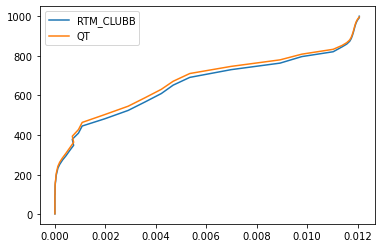

In [7]:
plt.plot(HTGcamDS_local['RTM_CLUBB'].values[0,:,0,0], HTGcamDS_local.ilev.values)
plt.plot(HTGcamDS_local['QT'].values[0,:,0,0], HTGcamDS_local.lev.values)
plt.legend(['RTM_CLUBB','QT'])

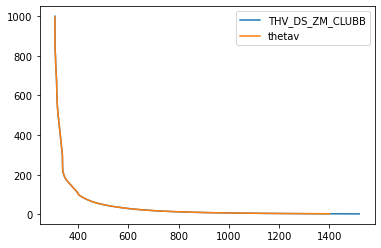

In [35]:
# plt.plot(HTGcamDS_local['THV_DS_ZM_CLUBB'].values[0,:,0,0], HTGcamDS_local.ilev.values)
# plt.plot(HTGcamDS_local['thetav'].values[0,:,0,0], HTGcamDS_local.lev.values)
# plt.legend(['THV_DS_ZM_CLUBB','thetav'])


In [9]:
levSel = 45
print('ilev at levSel: %.3i hPa' % HTGcamDS_local.ilev.values[levSel])

ilev at levSel: 691 hPa


In [51]:
# ## Timeseries of each of the terms that go into w'qt':

# turbProduction_HTG_lev2   = -(HTGcamDS_local.WP2_CLUBB.values[:,levSel,0,0] * HTGcamDS_local.dRTM_CLUBBdz.values[:,levSel])
# areturn2iso_HTG_lev2       = -(HTGcamDS_local.WPRTP_CLUBB_rate.values[:,levSel,0,0]/HTGcamDS_local.TAU_ZM_CLUBB.values[:,levSel,0,0])
# turbAdvection_HTG_lev2    = -HTGcamDS_local.dWP2RTP_CLUBBdz.values[:,levSel]
# # (1-C7)*(g/theta_vs)*rtpthvp
# buoyancyPressure_HTG_lev2 = (1-0.5)*(9.8/HTGcamDS_local.THV_DS_ZM_CLUBB.values[:,levSel,0,0])*HTGcamDS_local.RTPTHVP_CLUBB.values[:,levSel,0,0] 


# ## dWPRTPdt: 

# # dWPRTPdt = np.full([len(HTGcamDS_local.time.values)], np.nan)

# # for iTime in range(len(HTGcamDS_local.time.values)-1):
# #     dWPRTPdt[iTime] = (HTGcamDS_local.WPRTP_CLUBB_rate.values[iTime+1,-2,0,0]-HTGcamDS_local.WPRTP_CLUBB_rate.values[iTime,-2,0,0])/(60*5)
# testDifferentiate  = HTGcamDS_local.WPRTP_CLUBB_rate.differentiate("time",datetime_unit="s")

# testDifferentiate_HMG  = HMGcamDS_local.WPRTP_CLUBB_rate.differentiate("time",datetime_unit="s")



In [11]:
# ## Calculate w from omega (so from Pa/s to m/s):


# ## Also get virtual potential temperature
# HTG_w = mpc.vertical_velocity(HTGcamDS_local['OMEGA'] * units('Pa/s'), 
#                               plevm_HTG * units.pascals,
#                               HTGcamDS_local['T'] * units.kelvin,
#                               HTGcamDS_local['Q'] * units('kg/kg'))

# # Add to existing DS
# HTGcamDS_local['w_calc'] = (('time','lev','lat','lon'), np.asarray(HTG_w))
# HTGcamDS_local['w_calc'].attrs['units'] = 'm/s'
# HTGcamDS_local['w_calc'].attrs['long_name'] = 'Vertical velocity (from omega assuming hydrostatic conditions)'


In [88]:
# ## Calculate w from omega (so from Pa/s to m/s):


# ## Also get virtual potential temperature
# HMG_w = mpc.vertical_velocity(HMGcamDS_local['OMEGA'] * units('Pa/s'), 
#                               plevm_HMG * units.pascals,
#                               HMGcamDS_local['T'] * units.kelvin,
#                               HMGcamDS_local['Q'] * units('kg/kg'))

# # Add to existing DS
# HMGcamDS_local['w_calc'] = (('time','lev','lat','lon'), np.asarray(HMG_w))
# HMGcamDS_local['w_calc'].attrs['units'] = 'm/s'
# HMGcamDS_local['w_calc'].attrs['long_name'] = 'Vertical velocity (from omega assuming hydrostatic conditions)'



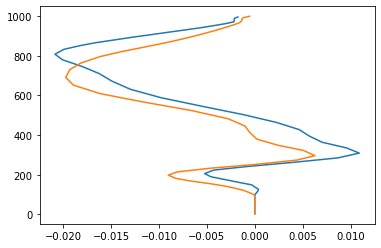

In [89]:
plt.plot(HMGcamDS_local['w_calc'].values[10,:,0,0],HMGcamDS_local['lev'].values)
plt.plot(HMGcamDS_local['WM_ZM_CLUBB'].values[10,:,0,0],HMGcamDS_local['ilev'].values)

In [78]:
# # Gradient of WPRTP with height
# pvarCLUBB2_HTG         = HTGcamDS_local['WPRTP_CLUBB_rate'].isel(lat=0,lon=0)
# pvarCLUBB2_HTG['ilev'] = zlevi_HTG[0,:].values
# dvardzCLUBB2_HTG       = pvarCLUBB2_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HTGcamDS_local['dWPRTP_CLUBB_RATEdz'] = (('time','ilev'), dvardzCLUBB2_HTG)


# # Gradient of w with height
# pvar2_HTG          = HTGcamDS_local['WM_ZM_CLUBB'].isel(lat=0,lon=0)
# pvar2_HTG['ilev']  = zlevi_HTG[0,:].values
# dvardz2_HTG        = pvar2_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HTGcamDS_local['dWdz'] = (('time','ilev'), dvardz2_HTG)


# # 2nd derivative of of WPRTP with height
# pvarCLUBB3_HTG         = HTGcamDS_local['dWPRTP_CLUBB_RATEdz']
# pvarCLUBB3_HTG['ilev'] = zlevi_HTG[0,:].values
# dvardzCLUBB3_HTG       = pvarCLUBB3_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), dvardzCLUBB3_HTG)


In [90]:
# # Gradient of WPRTP with height
# pvarCLUBB2_HMG         = HMGcamDS_local['WPRTP_CLUBB_rate'].isel(lat=0,lon=0)
# pvarCLUBB2_HMG['ilev'] = zlevi_HMG[0,:].values
# dvardzCLUBB2_HMG       = pvarCLUBB2_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HMGcamDS_local['dWPRTP_CLUBB_RATEdz'] = (('time','ilev'), dvardzCLUBB2_HMG)


# # Gradient of w with height
# pvar2_HMG          = HMGcamDS_local['WM_ZM_CLUBB'].isel(lat=0,lon=0)
# pvar2_HMG['ilev']  = zlevi_HMG[0,:].values
# dvardz2_HMG        = pvar2_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HMGcamDS_local['dWdz'] = (('time','ilev'), dvardz2_HMG)


# # 2nd derivative of of WPRTP with height
# pvarCLUBB3_HMG         = HMGcamDS_local['dWPRTP_CLUBB_RATEdz']
# pvarCLUBB3_HMG['ilev'] = zlevi_HMG[0,:].values
# dvardzCLUBB3_HMG       = pvarCLUBB3_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

# HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), dvardzCLUBB3_HMG)



In [122]:
## Convert the turbulent moisture flux (W/m2) to a rate (m/s)
# water_density = 1000.0 # kg/m3   Density of water 

latHeat_vap   = 2.501e6  # J/kg    Latent heat of vaporization
# m2mm          = 1000.0 #         convert from m/s to mm/s

HTGcamDS_local['WPRTP_CLUBB_rate'] = (('time','ilev','lat','lon'), 
                                    ((HTGcamDS_local.WPRTP_CLUBB.values)/(latHeat_vap*HTGcamDS_local.RHO_CLUBB.values)))

HMGcamDS_local['WPRTP_CLUBB_rate'] = (('time','ilev','lat','lon'), 
                                    ((HMGcamDS_local.WPRTP_CLUBB.values)/(latHeat_vap*HMGcamDS_local.RHO_CLUBB.values)))




In [123]:
## Update (10/12/2021): If we want to differentiate wrt height, but height changes with time, 
#                       need to differentiate at each time step....
#                       Ultimately it doesn't really make a noticeable difference, but seems more correct.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Set up the values of heights:
# - - - - - - - - - - - - - - - -
p0   = HTGcamDS_local['P0'].values[0] 

# Get pressure at each level
plevm_HTG = HTGcamDS_local['hyam']*p0 + HTGcamDS_local['hybm']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
plevi_HTG = HTGcamDS_local['hyai']*p0 + HTGcamDS_local['hybi']*HTGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
plevm_HTG.attrs['units'] = "Pa"
plevi_HTG.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm_HTG      = plevm_HTG
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HTG)) # Units of [m] after multiplied 
zlevm_HTG      = plevm_HTG.copy(deep=True)
zlevm_HTG[:,:] = zlevmHTG_vals

#    Interfaces 
zlevi_HTG      = plevi_HTG
zleviHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HTG)) # Units of [m] after multiplied 
zlevi_HTG      = plevi_HTG.copy(deep=True)
zlevi_HTG[:,:] = zleviHTG_vals

## Do the same for HMG case
p0_HMG   = HMGcamDS_local['P0'].values[0] 


# Get pressure at each level
plevm_HMG = HMGcamDS_local['hyam']*p0_HMG + HMGcamDS_local['hybm']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # Mid level
plevi_HMG = HMGcamDS_local['hyai']*p0_HMG + HMGcamDS_local['hybi']*HMGcamDS_local['PS'].isel(lat=0,lon=0) # interface level
plevm_HMG.attrs['units'] = "Pa"
plevi_HMG.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm_HMG      = plevm_HMG
zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_HMG)) # Units of [m] after multiplied 
zlevm_HMG      = plevm_HMG.copy(deep=True)
zlevm_HMG[:,:] = zlevmHMG_vals

#    Interfaces 
zlevi_HMG      = plevi_HMG
zleviHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevi_HMG)) # Units of [m] after multiplied 
zlevi_HMG      = plevi_HMG.copy(deep=True)
zlevi_HMG[:,:] = zleviHMG_vals



## Now go ahead and get derivatives at every time step... 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
nT     = len(HMGcamDS_local.time.values)
n_ilev = len(HMGcamDS_local.ilev.values)
n_lev  = len(HMGcamDS_local.lev.values)

rhos_HMG = HMGcamDS_local['RHO_CLUBB'].values[:,-1,0,0] 

dQTdz_HTG   = np.full([nT,n_ilev], np.nan)
dQTdz_HMG   = np.full([nT,n_ilev], np.nan)

dWP2RTP_HTG = np.full([nT,n_ilev], np.nan)
dWP2RTP_HMG = np.full([nT,n_ilev], np.nan)

dWPRTP_HTG  = np.full([nT,n_ilev], np.nan)
dWPRTP_HMG  = np.full([nT,n_ilev], np.nan)

dWM_HTG  = np.full([nT,n_ilev], np.nan)
dWM_HMG  = np.full([nT,n_ilev], np.nan)

for iT in range(nT):
    # Gradient of QT wrt height 
    QT_HTG          = HTGcamDS_local['RTM_CLUBB'].isel(time=iT,lat=0,lon=0)
    QT_HTG['ilev']  = zlevi_HTG[iT,:].values
    dQTdz_HTG[iT,:] = QT_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    QT_HMG          = HMGcamDS_local['RTM_CLUBB'].isel(time=iT,lat=0,lon=0)
    QT_HMG['ilev']  = zlevi_HMG[iT,:].values
    dQTdz_HMG[iT,:] = QT_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    # Gradient of WP2RTP with height
    WP2RTP_HTG         = HTGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
    WP2RTP_HTG['ilev'] = zlevi_HTG[iT,:].values
    dWP2RTP_HTG[iT,:]  = WP2RTP_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WP2RTP_HMG         = HMGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
#     WP2RTP_HMG         = rhos_HMG[iT] * HMGcamDS_local['WP2RTP_CLUBB'].isel(time=iT,lat=0,lon=0)
    WP2RTP_HMG['ilev'] = zlevi_HMG[iT,:].values
    dWP2RTP_HMG[iT,:]  = WP2RTP_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    # Gradient of WPRTP with height
    WPRTP_HTG         = HTGcamDS_local['WPRTP_CLUBB_rate'].isel(time=iT,lat=0,lon=0)
    WPRTP_HTG['ilev'] = zlevi_HTG[iT,:].values
    dWPRTP_HTG[iT,:]  = WPRTP_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WPRTP_HMG         = HMGcamDS_local['WPRTP_CLUBB_rate'].isel(time=iT,lat=0,lon=0)
    WPRTP_HMG['ilev'] = zlevi_HMG[iT,:].values
    dWPRTP_HMG[iT,:]  = WPRTP_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    # Gradient of WM_ZT_CLUBB wrt height 
    WM_HTG          = HTGcamDS_local['WM_ZM_CLUBB'].isel(time=iT,lat=0,lon=0)
    WM_HTG['ilev']  = zlevi_HTG[iT,:].values
    dWM_HTG[iT,:]   = WM_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
    WM_HMG          = HMGcamDS_local['WM_ZM_CLUBB'].isel(time=iT,lat=0,lon=0)
    WM_HMG['ilev']  = zlevi_HMG[iT,:].values
    dWM_HMG[iT,:]   = WM_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    if (iT % 500)==0:
        print('Done with %.2f percent of timesteps' % ((iT/nT)*100))

HTGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dQTdz_HTG)
HMGcamDS_local['dRTM_CLUBBdz'] = (('time','ilev'), dQTdz_HMG)

HTGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dWP2RTP_HTG)
HMGcamDS_local['dWP2RTP_CLUBBdz'] = (('time','ilev'), dWP2RTP_HMG)

HTGcamDS_local['dWPRTP_CLUBBdz'] = (('time','ilev'), dWPRTP_HTG)
HMGcamDS_local['dWPRTP_CLUBBdz'] = (('time','ilev'), dWPRTP_HMG)

HTGcamDS_local['dWdz'] = (('time','ilev'), dWM_HTG)
HMGcamDS_local['dWdz'] = (('time','ilev'), dWM_HMG)

dWPRTPdt_HTG  = HTGcamDS_local['WPRTP_CLUBB_rate'].differentiate("time",datetime_unit="s")
dWPRTPdt_HMG  = HMGcamDS_local['WPRTP_CLUBB_rate'].differentiate("time",datetime_unit="s")



KeyError: 'WM_ZM_CLUBB'

In [ ]:
# 2nd derivative of WPRTP wrt height

# d2WPRTPdz2_HTG = np.full([nT,n_ilev], np.nan)
d2WPRTPdz2_HMG = np.full([nT,n_ilev], np.nan)

for iT in range(nT):
    # Gradient of QT wrt height 
    dWPRTPdz_HTG         = HTGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
    dWPRTPdz_HTG['ilev'] = zlevi_HTG[iT,:].values
    d2WPRTPdz2_HTG[iT,:] = dWPRTPdz_HTG.differentiate("ilev") # Find field gradient wrt HEIGHT!

    dWPRTPdz_HMG         = HMGcamDS_local['dWPRTP_CLUBBdz'].isel(time=iT)
    dWPRTPdz_HMG['ilev'] = zlevi_HMG[iT,:].values
    d2WPRTPdz2_HMG[iT,:] = dWPRTPdz_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!
    
HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), d2WPRTPdz2_HTG)
HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), d2WPRTPdz2_HMG)



In [91]:
meanAdv  = -(HTGcamDS_local['WM_ZM_CLUBB'].values[:,:,0,0]*HTGcamDS_local['dWPRTP_CLUBB_RATEdz'].values[:,:])
turbTransp = -(HTGcamDS_local['dWP2RTP_CLUBBdz'].values[:,:])
turbProd = -(HTGcamDS_local.WP2_CLUBB.values[:,:,0,0] * HTGcamDS_local.dRTM_CLUBBdz.values[:,:])
accum    = -(HTGcamDS_local.WPRTP_CLUBB_rate.values[:,:,0,0] * HTGcamDS_local['dWdz'].values[:,:])
buoyProd = (9.8/HTGcamDS_local.THV_DS_ZM_CLUBB.values[:,:,0,0])*(HTGcamDS_local.RTPTHVP_CLUBB.values[:,:,0,0])
pressureApprox = -(HTGcamDS_local.WPRTP_CLUBB_rate.values[:,:,0,0]/HTGcamDS_local.TAU_ZM_CLUBB.values[:,:,0,0])-(0.5*(9.8/HTGcamDS_local.THV_DS_ZM_CLUBB.values[:,:,0,0])*(HTGcamDS_local.RTPTHVP_CLUBB.values[:,:,0,0])) 
dissipation    = -(-30.0 * HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,:])

sumTerms = meanAdv+turbTransp+turbProd+accum+buoyProd+pressureApprox+dissipation
residual = testDifferentiate[:,:,0,0] - sumTerms


NameError: name 'HTGcamDS_local' is not defined

Time selected:  2015-06-03T11:12:15.000000000


Text(0.5, 1.0, 'wprtp terms @ time 2015-06-03T11:12:15.000000000')

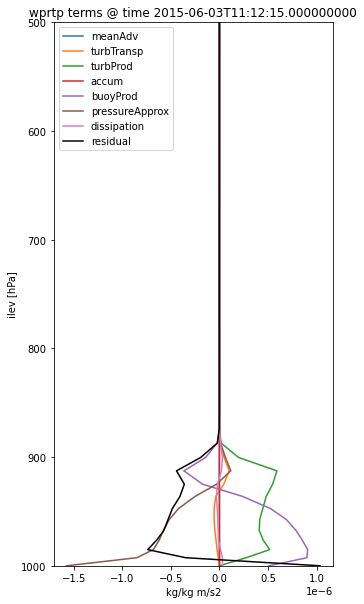

In [84]:
timeSel = 200
print('Time selected: ',HTGcamDS_local.time.values[timeSel])

fig,axs = plt.subplots(1,1, figsize=(5,10))
axs.plot(meanAdv[timeSel,:], HTGcamDS_local.ilev.values, label='meanAdv')
axs.plot(turbTransp[timeSel,:], HTGcamDS_local.ilev.values, label='turbTransp')
axs.plot(turbProd[timeSel,:], HTGcamDS_local.ilev.values, label='turbProd')
axs.plot(accum[timeSel,:], HTGcamDS_local.ilev.values, label='accum')
axs.plot(buoyProd[timeSel,:], HTGcamDS_local.ilev.values, label='buoyProd')
axs.plot(pressureApprox[timeSel,:], HTGcamDS_local.ilev.values, label='pressureApprox')
axs.plot(dissipation[timeSel,:], HTGcamDS_local.ilev.values, label='dissipation')
axs.plot(residual[timeSel,:], HTGcamDS_local.ilev.values,'k', label='residual')

axs.legend()
axs.set_ylim([500,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('wprtp terms @ time '+str(HTGcamDS_local.time.values[timeSel]))



Time selected:  2015-06-03T14:32:15.000000000


Text(0.5, 1.0, 'HTG wprtp terms @ time 2015-06-03T14:32:15.000000000')

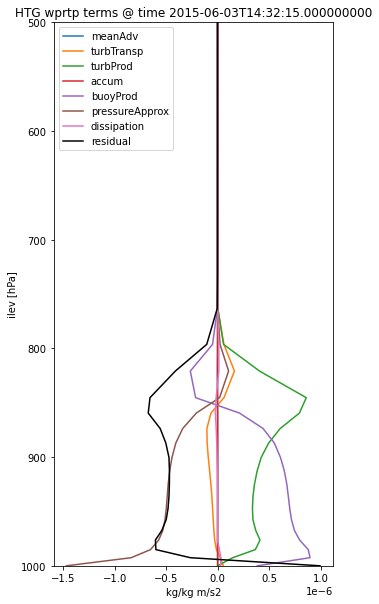

In [86]:
timeSel = 240
print('Time selected: ',HTGcamDS_local.time.values[timeSel])

fig,axs = plt.subplots(1,1, figsize=(5,10))
axs.plot(meanAdv[timeSel,:], HTGcamDS_local.ilev.values, label='meanAdv')
axs.plot(turbTransp[timeSel,:], HTGcamDS_local.ilev.values, label='turbTransp')
axs.plot(turbProd[timeSel,:], HTGcamDS_local.ilev.values, label='turbProd')
axs.plot(accum[timeSel,:], HTGcamDS_local.ilev.values, label='accum')
axs.plot(buoyProd[timeSel,:], HTGcamDS_local.ilev.values, label='buoyProd')
axs.plot(pressureApprox[timeSel,:], HTGcamDS_local.ilev.values, label='pressureApprox')
axs.plot(dissipation[timeSel,:], HTGcamDS_local.ilev.values, label='dissipation')
axs.plot(residual[timeSel,:], HTGcamDS_local.ilev.values,'k', label='residual')



axs.legend()
axs.set_ylim([500,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HTG wprtp terms @ time '+str(HTGcamDS_local.time.values[timeSel]))


In [92]:
meanAdvHMG  = -(HMGcamDS_local['WM_ZM_CLUBB'].values[:,:,0,0]*HMGcamDS_local['dWPRTP_CLUBB_RATEdz'].values[:,1::])
turbTranspHMG = -(HMGcamDS_local['dWP2RTP_CLUBBdz'].values[:,1::])
turbProdHMG = -(HMGcamDS_local.WP2_CLUBB.values[:,1:,0,0] * HMGcamDS_local.dRTM_CLUBBdz.values[:,1:])
accumHMG    = -(HMGcamDS_local.WPRTP_CLUBB_rate.values[:,1:,0,0] * HMGcamDS_local['dWdz'].values[:,:])
buoyProdHMG = (9.8/HMGcamDS_local.THV_DS_ZM_CLUBB.values[:,1:,0,0])*(HMGcamDS_local.RTPTHVP_CLUBB.values[:,1:,0,0])
pressureApproxHMG = -(HMGcamDS_local.WPRTP_CLUBB_rate.values[:,1:,0,0]/HMGcamDS_local.TAU_ZM_CLUBB.values[:,1:,0,0])-(0.5*(9.8/HTGcamDS_local.THV_DS_ZM_CLUBB.values[:,1:,0,0])*(HTGcamDS_local.RTPTHVP_CLUBB.values[:,1:,0,0])) 

# pressureApprox1HMG = -(4*HMGcamDS_local.WPRTP_CLUBB_rate.values[:,1:,0,0]/HMGcamDS_local.TAU_ZM_CLUBB.values[:,1:,0,0])
# pressureApprox2HMG = 0.5*HMGcamDS_local.WPRTP_CLUBB_rate.values[:,1:,0,0]*HMGcamDS_local['dWdz'].values[:,:]
# pressureApprox3HMG = -(0.5*(9.8/HTGcamDS_local.THV_DS_ZM_CLUBB.values[:,1:,0,0])*(HTGcamDS_local.RTPTHVP_CLUBB.values[:,1:,0,0])) 
# pressureApproxHMG = pressureApprox1HMG+pressureApprox2HMG+pressureApprox3HMG

dissipationHMG    = -(-30.0 * HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,1:])

sumTermsHMG = meanAdvHMG+turbTranspHMG+turbProdHMG+accumHMG+buoyProdHMG+pressureApproxHMG+dissipationHMG
residualHMG = testDifferentiate_HMG[:,1:,0,0] - sumTermsHMG



ValueError: operands could not be broadcast together with shapes (8641,65) (8641,64) 

Time selected:  2015-06-01T14:27:15.000000000


Text(0.5, 1.0, 'HMG wprtp terms @ time 2015-06-01T14:27:15.000000000')

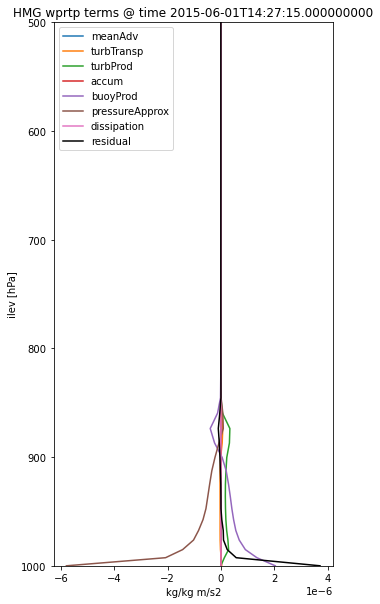

In [97]:
timeSel = 240
print('Time selected: ',HMGcamDS_local.time.values[timeSel])

fig,axs = plt.subplots(1,1, figsize=(5,10))
axs.plot(meanAdvHMG[timeSel,:], HMGcamDS_local.ilev.values, label='meanAdv')
axs.plot(turbTranspHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbTransp')
axs.plot(turbProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='turbProd')
axs.plot(accumHMG[timeSel,:], HMGcamDS_local.ilev.values, label='accum')
axs.plot(buoyProdHMG[timeSel,:], HMGcamDS_local.ilev.values, label='buoyProd')
axs.plot(pressureApproxHMG[timeSel,:], HMGcamDS_local.ilev.values, label='pressureApprox')
axs.plot(dissipationHMG[timeSel,:], HMGcamDS_local.ilev.values, label='dissipation')
axs.plot(residualHMG[timeSel,:], HMGcamDS_local.ilev.values,'k', label='residual')



axs.legend()
axs.set_ylim([500,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HMG wprtp terms @ time '+str(HMGcamDS_local.time.values[timeSel]))




Time selected:  2015-06-03T14:32:15.000000000


Text(0.5, 1.0, 'HMG wprtp terms @ time 2015-06-03T14:32:15.000000000')

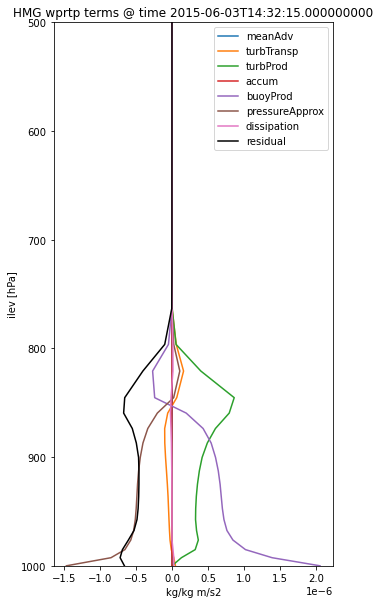

In [63]:
timeSel = 240
print('Time selected: ',HTGcamDS_local.time.values[timeSel])

fig,axs = plt.subplots(1,1, figsize=(5,10))
axs.plot(meanAdvHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='meanAdv')
axs.plot(turbTranspHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='turbTransp')
axs.plot(turbProdHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='turbProd')
axs.plot(accumHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='accum')
axs.plot(buoyProdHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='buoyProd')
axs.plot(pressureApproxHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='pressureApprox')
axs.plot(dissipationHMG[timeSel,:], HTGcamDS_local.ilev.values[1:], label='dissipation')
axs.plot(residualHMG[timeSel,:], HTGcamDS_local.ilev.values[1:],'k', label='residual')



axs.legend()
axs.set_ylim([500,1000])
axs.invert_yaxis()
axs.set_xlabel('kg/kg m/s2')
axs.set_ylabel('ilev [hPa]')
axs.set_title('HMG wprtp terms @ time '+str(HTGcamDS_local.time.values[timeSel]))



In [22]:
term1 = -(HTGcamDS_local['w_calc'].values[:,levSel,0,0]*HTGcamDS_local['dWPRTP_CLUBB_RATEdz'].values[:,levSel])
term2 = -(HTGcamDS_local['WPRTP_CLUBB_rate'].values[:,levSel,0,0]*HTGcamDS_local['dWdz'].values[:,levSel])
term3 = -(-30.0 * HTGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,levSel])

clubb_terms = term1+term2+term3
sum_terms = clubb_terms+turbProduction_HTG_lev2+areturn2iso_HTG_lev2+turbAdvection_HTG_lev2+buoyancyPressure_HTG_lev2



ValueError: operands could not be broadcast together with shapes (9423,64) (9423,65) 

In [19]:
HTGcamDS_local.time.values[200]

numpy.datetime64('2015-06-03T11:12:15.000000000')

In [20]:
iTime=200

# clubb_terms = term1[iTime]+term2[iTime]+term3[iTime]
# sum_terms = clubb_terms+turbProduction_HTG_lev2[iTime]+areturn2iso_HTG_lev2[iTime]+(turbAdvection_HTG_lev2[iTime])+buoyancyPressure_HTG_lev2[iTime] 

print('Balance of wprtp terms at timestep #',iTime,' (and ilev ',levSel,') : ')
print('Turb Production:     %10.3e kg/kg m/s2' % turbProduction_HTG_lev2[iTime])
print('Return2iso:          %10.3e kg/kg m/s2' % areturn2iso_HTG_lev2[iTime] )
print('turbAdvection:       %10.3e kg/kg m/s2' % turbAdvection_HTG_lev2[iTime])
print('buoyancyPressure:    %10.3e kg/kg m/s2' % buoyancyPressure_HTG_lev2[iTime])
print('Extra terms (CLUBB): %10.3e kg/kg m/s2' % clubb_terms[iTime])
print()
print('Sum of terms:        %10.3e kg/kg m/s2' % sum_terms[iTime] )
print('d/dt(wprtp):         %10.3e kg/kg m/s2' % testDifferentiate.values[iTime,levSel,0,0])
print('Difference between d/dt (wprtp) and sum of terms: %10.3e kg/kg m/s2' % (testDifferentiate.values[iTime,levSel,0,0]-sum_terms[iTime]))



Balance of wprtp terms at timestep # 200  (and ilev  45 ) : 
Turb Production:      1.099e-09 kg/kg m/s2
Return2iso:          -5.499e-11 kg/kg m/s2
turbAdvection:        2.461e-17 kg/kg m/s2
buoyancyPressure:    -1.116e-10 kg/kg m/s2
Extra terms (CLUBB):  1.049e-12 kg/kg m/s2

Sum of terms:         9.331e-10 kg/kg m/s2
d/dt(wprtp):          2.857e-13 kg/kg m/s2
Difference between d/dt (wprtp) and sum of terms: -9.329e-10 kg/kg m/s2


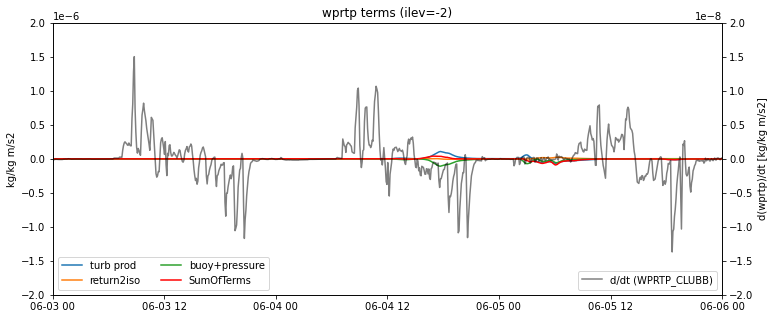

In [21]:
fig,axs = plt.subplots(1,1, figsize=(12,5))

# sum_terms = clubb_terms+turbProduction_HTG_lev2+areturn2iso_HTG_lev2+turbAdvection_HTG_lev2+buoyancyPressure_HTG_lev2



axs.plot(HTGcamDS_local.time.values, turbProduction_HTG_lev2, label='turb prod')
axs.plot(HTGcamDS_local.time.values, areturn2iso_HTG_lev2, label='return2iso')
axs.plot(HTGcamDS_local.time.values, buoyancyPressure_HTG_lev2, label='buoy+pressure')
# axs.plot(dDryDays_HTG.time.values, turbAdvection_HTG_lev2, label='turb adv')


axs.plot(HTGcamDS_local.time.values, sum_terms,'r',label='SumOfTerms')
# axs.plot(dDryDays_HTG.time.values, (dDryDays_HTG.WPRTP_CLUBB_rate.values[:,-2,0,0]),'k',
#          linewidth=3,alpha=0.7,label='WPRTP_CLUBB')
axs.legend(ncol=2,loc='lower left')
axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,6)])

axs.set_ylabel('kg/kg m/s2')
axs.set_ylim([-2e-6,2e-6])
axs.set_title('wprtp terms (ilev=-2)')

ax2 = axs.twinx()
# ax2.plot(HTGcamDS_local.time.values, HTGcamDS_local.WPRTP_CLUBB.values[:,-2,0,0],'k', alpha = 0.5, label ='WPRTP_CLUBB')
# ax2.set_ylabel('wprtp [W/m2]')
# ax2.set_ylim([-200,200])

ax2.plot(HTGcamDS_local.time.values, testDifferentiate.values[:,-2,0,0],'k',alpha=0.5, label='d/dt (WPRTP_CLUBB)')
ax2.set_ylabel('d(wprtp)/dt [kg/kg m/s2]')
ax2.set_ylim([-2e-8,2e-8])

ax2.legend(loc='lower right')



(16589.0, 16592.0)

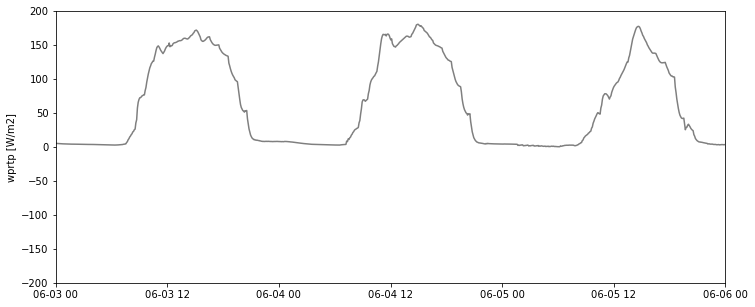

In [58]:
fig,axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(HTGcamDS_local.time.values, HTGcamDS_local.WPRTP_CLUBB.values[:,-2,0,0],'k', alpha = 0.5, label ='WPRTP_CLUBB')
axs.set_ylabel('wprtp [W/m2]')
axs.set_ylim([-200,200])

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,6)])




**HMG CASE?**


In [20]:
## Timeseries of each of the terms that go into w'qt':

turbProduction_HMG_lev2   = -(HMGcamDS_local.WP2_CLUBB.values[:,-2,0,0] * HMGcamDS_local.dRTM_CLUBBdz.values[:,-2])
areturn2iso_HMG_lev2       = -(HMGcamDS_local.WPRTP_CLUBB_rate.values[:,-2,0,0]/HMGcamDS_local.TAU_ZM_CLUBB.values[:,-2,0,0])
turbAdvection_HMG_lev2    = -HMGcamDS_local.dWP2RTP_CLUBBdz.values[:,-2]
# (1-C7)*(g/theta_vs)*rtpthvp
buoyancyPressure_HMG_lev2 = (1-0.5)*(9.8/HMGcamDS_local.THV_DS_ZM_CLUBB.values[:,-2,0,0])*HMGcamDS_local.RTPTHVP_CLUBB.values[:,-2,0,0] 


## dWPRTPdt: 

# dWPRTPdt = np.full([len(HTGcamDS_local.time.values)], np.nan)

# for iTime in range(len(HTGcamDS_local.time.values)-1):
#     dWPRTPdt[iTime] = (HTGcamDS_local.WPRTP_CLUBB_rate.values[iTime+1,-2,0,0]-HTGcamDS_local.WPRTP_CLUBB_rate.values[iTime,-2,0,0])/(60*5)
dWPRTPdt  = HMGcamDS_local.WPRTP_CLUBB_rate.differentiate("time",datetime_unit="s")




In [17]:
## Calculate w from omega (so from Pa/s to m/s):


## Also get virtual potential temperature
HMG_w = mpc.vertical_velocity(HMGcamDS_local['OMEGA'] * units('Pa/s'), 
                              plevm_HMG * units.pascals,
                              HMGcamDS_local['T'] * units.kelvin,
                              HMGcamDS_local['Q'] * units('kg/kg'))

# Add to existing DS
HMGcamDS_local['w_calc'] = (('time','lev','lat','lon'), np.asarray(HMG_w))
HMGcamDS_local['w_calc'].attrs['units'] = 'm/s'
HMGcamDS_local['w_calc'].attrs['long_name'] = 'Vertical velocity (from omega assuming hydrostatic conditions)'



In [18]:
# Gradient of WPRTP with height
pvarCLUBB2_HMG         = HMGcamDS_local['WPRTP_CLUBB_rate'].isel(lat=0,lon=0)
pvarCLUBB2_HMG['ilev'] = zlevi_HMG[0,:].values
dvardzCLUBB2_HMG       = pvarCLUBB2_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

HMGcamDS_local['dWPRTP_CLUBB_RATEdz'] = (('time','ilev'), dvardzCLUBB2_HMG)


# Gradient of w with height
pvar2_HMG         = HMGcamDS_local['w_calc'].isel(lat=0,lon=0)
pvar2_HMG['lev']  = zlevm_HMG[0,:].values
dvardz2_HMG       = pvar2_HMG.differentiate("lev") # Find field gradient wrt HEIGHT!

HMGcamDS_local['dWdz'] = (('time','lev'), dvardz2_HMG)


# 2nd derivative of of WPRTP with height
pvarCLUBB3_HMG         = HMGcamDS_local['dWPRTP_CLUBB_RATEdz']
pvarCLUBB3_HMG['ilev'] = zlevi_HMG[0,:].values
dvardzCLUBB3_HMG       = pvarCLUBB3_HMG.differentiate("ilev") # Find field gradient wrt HEIGHT!

HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'] = (('time','ilev'), dvardzCLUBB3_HMG)



In [24]:
term1_hmg = -(HMGcamDS_local['w_calc'].values[:,-2,0,0]*HMGcamDS_local['dWPRTP_CLUBB_RATEdz'].values[:,-2])
term2_hmg = -(HMGcamDS_local['WPRTP_CLUBB_rate'].values[:,-2,0,0]*HMGcamDS_local['dWdz'].values[:,-2])
term3_hmg = -(-30.0 * HMGcamDS_local['dWPRTP_CLUBB_RATEdz2'].values[:,-2])

clubb_terms_hmg = term1_hmg+term2_hmg+term3_hmg
sum_terms_hmg = clubb_terms_hmg+turbProduction_HMG_lev2+areturn2iso_HMG_lev2+turbAdvection_HMG_lev2+buoyancyPressure_HMG_lev2




In [25]:
iTime=40

# clubb_terms = term1[iTime]+term2[iTime]+term3[iTime]
# sum_terms = clubb_terms+turbProduction_HTG_lev2[iTime]+areturn2iso_HTG_lev2[iTime]+(turbAdvection_HTG_lev2[iTime])+buoyancyPressure_HTG_lev2[iTime] 

print('Turb Production:  ',turbProduction_HMG_lev2[iTime])
print('Return2iso:       ',areturn2iso_HMG_lev2[iTime] )
print('turbAdvection:    ',turbAdvection_HMG_lev2[iTime])
print('buoyancyPressure: ',buoyancyPressure_HMG_lev2[iTime])
print('Extra terms (CLUBB): ', clubb_terms_hmg[iTime])
print('Sum of terms:     ',sum_terms_hmg[iTime] )
print()
print('d/dt(wprtp):      ', dWPRTPdt.values[iTime,-2,0,0])
print('Difference between d/dt (wprtp) and sum of terms: ', dWPRTPdt.values[iTime,-2,0,0]-sum_terms_hmg[iTime])




Turb Production:   7.4681964e-08
Return2iso:        -3.60157e-08
turbAdvection:     -3.1075347e-11
buoyancyPressure:  1.0703771e-09
Extra terms (CLUBB):  2.209867145444097e-09
Sum of terms:      4.191543377516045e-08

d/dt(wprtp):       -2.3999672e-10
Difference between d/dt (wprtp) and sum of terms:  -4.215543049210464e-08


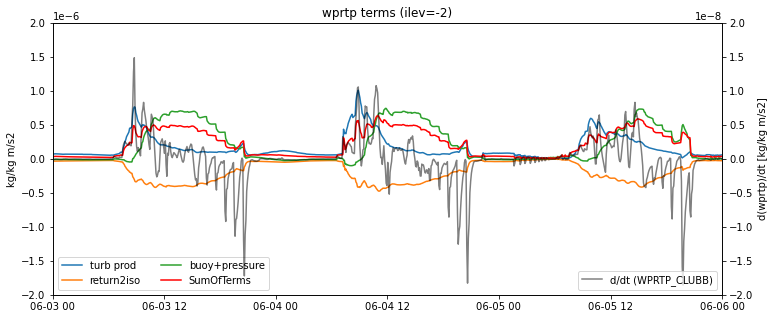

In [26]:
fig,axs = plt.subplots(1,1, figsize=(12,5))

axs.plot(HMGcamDS_local.time.values, turbProduction_HMG_lev2, label='turb prod')
axs.plot(HMGcamDS_local.time.values, areturn2iso_HMG_lev2, label='return2iso')
axs.plot(HMGcamDS_local.time.values, buoyancyPressure_HMG_lev2, label='buoy+pressure')
# axs.plot(dDryDays_HTG.time.values, turbAdvection_HTG_lev2, label='turb adv')


axs.plot(HTGcamDS_local.time.values, sum_terms_hmg,'r',label='SumOfTerms')
# axs.plot(dDryDays_HTG.time.values, (dDryDays_HTG.WPRTP_CLUBB_rate.values[:,-2,0,0]),'k',
#          linewidth=3,alpha=0.7,label='WPRTP_CLUBB')
axs.legend(ncol=2,loc='lower left')
axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,6)])

axs.set_ylabel('kg/kg m/s2')
axs.set_ylim([-2e-6,2e-6])
axs.set_title('wprtp terms (ilev=-2)')

ax2 = axs.twinx()
# ax2.plot(HTGcamDS_local.time.values, HTGcamDS_local.WPRTP_CLUBB.values[:,-2,0,0],'k', alpha = 0.5, label ='WPRTP_CLUBB')
# ax2.set_ylabel('wprtp [W/m2]')
# ax2.set_ylim([-200,200])

ax2.plot(HMGcamDS_local.time.values, dWPRTPdt.values[:,-2,0,0],'k',alpha=0.5, label='d/dt (WPRTP_CLUBB)')
ax2.set_ylabel('d(wprtp)/dt [kg/kg m/s2]')
ax2.set_ylim([-2e-8,2e-8])

ax2.legend(loc='lower right')


